In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
})
plt.rcParams['font.size'] = 12
from matplotlib.transforms import Affine2D
from mpl_toolkits.axisartist.floating_axes import FloatingSubplot, GridHelperCurveLinear

# **Hadronization**
### ***Summary: In this tutorial, we'll develop an algorithm to hadronize a simple color-connected quark anti-quark ($q\bar{q}$) system.***

Colliders probe energy scales where quarks and gluons interact perturbatively. As we saw in the previous tutorial, hard scattering events often produce colored partons that evolve via parton showers, radiating additional quarks and gluons. At the detector level, far below the QCD confinement scale, only color-neutral composite particles such as mesons, baryons, and occasionally exotic hadrons (e.g. tetraquarks or pentaquarks) are observed. To bridge this gap, Monte Carlo event generators must model the **nonperturbative** process that converts colored final state particles from the parton shower into observable hadrons. This process is known as ***hadronization***. Many phenomenological models of hadronization exist, however, in modern event generators two models are favored: the ***Lund string model*** (Pythia) and the ***cluster model*** (Herwig, Sherpa). In this tutorial, we'll focus exclusively on the Lund string model. 

## **Lund string model**
In QCD the potential between a static quark and anti-quark as a function of the distance between them is found to be
$$
V_{q\bar{q}}(r) \approx -\frac{4\alpha_s}{3}\frac{1}{r} + \kappa r .
$$
At short distances ($r < 0.1$ fm), the $1/r$ piece (stemming from one-gluon exchange - **Exercise:** Show that the short distance potential is given above by computing explicitly in QFT) dominates and the quarks behave as free 'Coulomb-like' charged particles. At long distances, the linear component dominates - representing the collapse of gluonic field lines into a thin color flux tube or **string** with a constant **tension** (linear energy density) $\kappa \simeq 1 \text{ GeV/fm} \simeq 0.2 \text{ GeV}^2$.

Consider center-of-mass frame of a $q_i \bar{q}_i$ system where the (massless) partons, each with flavor index $i$ and initial energy $E$, travel with equal and opposite momenta along the $z$-axis. As the separation increases the confining force causes an approximately uniform cylindrical string (flux tube) of color field to form between the quark pair. In the absence of string breaks, our $q\bar{q}$ system would follow an infinite ***"yo-yo" motion*** whereby the the systems energy oscillates between the kinetic energy of the quarks and the energy contained in the string.

If we allow for string breaking during the separation process the energy in the string can be used to create $q'\bar{q}'$ pairs out of the vacuum. This production breaks the original string into two fragments: a composite hadron $h \equiv  q_i\bar{q}'$ (or $q' \bar{q_i}$) and another $q'\bar{q}_i$ (or $q_i \bar{q}'$)-string system. The ejected hadron inherits kinematics according to the model (and whose microscopic description in this model would be that of a mini-string following stable yo-yo motion as described above, i.e., **yoyo-hadrons**). The remaining string system continues its evolution and potentially fragments further into more hadrons.
<p align="center">
  <img src="./hadronization.png" />
</p>

In [1]:
from utils.vector import FourVector
from utils.particle import ParticleData, Particle

Let's define a small particle database which we will use throughout using the predefined `ParticleData` utility class located `./utils/`.

In [3]:
# Define up and down quarks as Particle instances
pid_u  = 2
name_u = "u"
mass_u = 0.0
charge_u = 2/3

pid_d  = 1
name_d = "d"
mass_d = 0.0
charge_d = -1/3

# Create ParticleData instances for u, ubar, d, and dbar
u = ParticleData(pid=pid_u, name=name_u, mass=mass_u, charge=charge_u)
ubar = -u
d = ParticleData(pid=pid_d, name=name_d, mass=mass_d, charge=charge_d)
dbar = -d

# Print out the ParticleData instances
print(u)
print()
print(ubar)
print()

# Define pions as Particle instances
pid_pi_plus    = 211
name_pi_plus   = "pi+"
mass_pi_plus   = 0.13957 # GeV
charge_pi_plus = 1

pid_pi0  = 111
name_pi0 = "pi0"
mass_pi0 = 0.134977 # GeV
charge_pi0 = 0.

pi_plus = ParticleData(pid=pid_pi_plus, name=name_pi_plus, mass=mass_pi_plus, charge=charge_pi_plus)
pi_minus = -pi_plus

print(pi_minus,'\n')

pi0 = ParticleData(pid=pid_pi0, name=name_pi0, mass=mass_pi0, charge=charge_pi0)

ParticleDatabase = {}

# Add the quarks and pions to the particle database
ParticleDatabase[f'{u.name}'] = u
ParticleDatabase[f'{ubar.name}'] = ubar
ParticleDatabase[f'{d.name}'] = d
ParticleDatabase[f'{dbar.name}'] = dbar
ParticleDatabase[f'{pi_plus.name}'] = pi_plus
ParticleDatabase[f'{pi_minus.name}'] = pi_minus
ParticleDatabase[f'{pi0.name}'] = pi0

print('Particle database:\n', ParticleDatabase)

   pid: 2
  name: u
  mass: 0.0
   tau: None
  spin: None
charge: 0.6666666666666666
colour: None

   pid: -2
  name: ubar
  mass: 0.0
   tau: None
  spin: None
charge: -0.6666666666666666
colour: None

   pid: -211
  name: pi-
  mass: 0.13957
   tau: None
  spin: None
charge: -1
colour: None 

Particle database:
 {'u': ParticleData(2, 'u', 0.0, None, None, 0.6666666666666666, None), 'ubar': ParticleData(-2, 'ubar', 0.0, None, None, -0.6666666666666666, None), 'd': ParticleData(1, 'd', 0.0, None, None, -0.3333333333333333, None), 'dbar': ParticleData(-1, 'dbar', 0.0, None, None, 0.3333333333333333, None), 'pi+': ParticleData(211, 'pi+', 0.13957, None, None, 1, None), 'pi-': ParticleData(-211, 'pi-', 0.13957, None, None, -1, None), 'pi0': ParticleData(111, 'pi0', 0.134977, None, None, 0.0, None)}


Let's write a class to represent our string system built out of `FourVector` and `ParticleData` instances:

In [4]:
class QQBarString:
        """
        Class to represent a quark-antiquark pair.
        """
        def __init__(self, Eq, Eqbar, ParticleData):
                if Eq == Eqbar: self.E = Eq
                # We'll using the convention (E, px, py, pz) for FourVectors.
                self.q_p    = FourVector(Eq, 0, 0, Eq)  # GeV 
                self.qbar_p = FourVector(Eqbar, 0, 0, -Eqbar) # GeV

                self.q    = Particle(data = ParticleData, p=self.q_p, h=0.)
                self.qbar = Particle(data = -ParticleData, p=self.qbar_p, h=0.)

                # Define the invariant mass squared of the qqbar pair
                self.M2 = 2 * Eq * 2 * Eqbar  # GeV^2
        
        def __repr__(self):
                return f"QBarQ(   q:FourVector(E={self.q_p[0]:.3f}, px={self.q_p[1]:.3f}, py={self.q_p[1]:.3f}, pz={self.q_p[3]:.3f}, m={np.sqrt(self.q_p[0]**2 - self.q_p[1]**2 - self.q_p[2]**2 - self.q_p[3]**2):.3f}),\n" +\
                       f"      qbar:FourVector(E={self.qbar_p[0]:.3f}, px={self.qbar_p[1]:.3f}, py={self.qbar_p[2]:.3f}, pz={self.qbar_p[3]:.3f}, m={np.sqrt(self.qbar_p[0]**2 - self.qbar_p[1]**2 - self.qbar_p[2]**2 - self.qbar_p[3]**2):.3f}))"

In [5]:
# Define the energy for each string end
e = 50.0 # GeV

# Create a QQBarString instance with the predefined quarks
qqbar = QQBarString(Eq = e, Eqbar = e, ParticleData = u)
print(qqbar)

# We can access the data of both string ends straightforwardly
print(f"{qqbar.q.data.name}:\n", qqbar.q.data,'\n')
print(f"{qqbar.qbar.data.name}:\n", qqbar.q.data)

QBarQ(   q:FourVector(E=50.000, px=0.000, py=0.000, pz=50.000, m=0.000),
      qbar:FourVector(E=50.000, px=0.000, py=0.000, pz=-50.000, m=0.000))
u:
    pid: 2
  name: u
  mass: 0.0
   tau: None
  spin: None
charge: 0.6666666666666666
colour: None 

ubar:
    pid: 2
  name: u
  mass: 0.0
   tau: None
  spin: None
charge: 0.6666666666666666
colour: None


## **Coordinates**
In the string model, hadronization is typically implemented in **momentum space** as an iterative stochastic walk through production (string-break) vertices, $v_i$. Because each string end is massless, they both follow lightlike trajectories, motivating the use of ***light-cone coordinates***. Given an arbitrary four-momentum $p^\mu = (E, \vec{p})$, the light-cone momenta are defined as: 
$$
p^\pm = E \pm p_z
$$
and satisfy (in 1 + 1 dimensions)
$$
p^+ p^- = m^2.
$$
Under Lorentz boosts, like cone momenta have simple transformation properties
$$
p^{\pm'} = k^{\pm 1} p^\pm, \quad \text{where } k = \sqrt{\frac{1+\beta}{1-\beta}}  
$$
with $\beta$ denoting the boost velocity.

The string itself has total light-cone momenta (defined at $t = 0$):
$$
P^+ = p_q^+ + p_{\bar{q}}^+, \quad P^- = p_q^- + q_{\bar{q}}^-
$$
which in the string rest frame (both ends with equal energy, $E$, and opposite momenta along the $z$-axis, $p_z$) becomes
$$
P^+ = 2E, \quad P^- = 2E, \quad P^+ P^- = M^2 = 4 E^2
$$
where $M$ is the **string mass**.

To further describe the fragmentation in dimensionless, string-normalized coordinates we also introduce:
- **Light-cone momentum fractions**, $x^{\pm}$, representing the light-cone separation between two breaks and defined as $$ x_i^{\pm} = \frac{p_i^\pm}{P^\pm}$$ for the $i$-th hadron. These satisfy: $$x^+_i x^-_i = \frac{m_i^2}{M^2}.$$ For a specified hadron mass, we thus have a fixed relationship between $x^+_i$ and $x^-_i$. Note that the momentum fractions are normalized to the quark turning points such that $0 \leq x^{\pm} \leq 1$. The figure below gives a useful schematic depiction of a fully hadronized string in energy-momentum space 
<p align="center">
  <img src="./momentum_space_string.png" />
</p>

where $\hat{x}^{\pm}$ represent **light-cone vertex coordinates**, describing the location of production vertices.

Very broadly, the hadronization of a string can be categorized into two methods: 
1. ***Flavor production***: we need to choose the flavor of the hadrons that get produced and
2. ***Kinematics***: we need to assign some four-momenta to each of the produced hadrons. 
Before jumping into the full hadronization algorithm we'll take a detour to build each of these components.

## **Flavor**
Here, for simplicity, we'll restrict the string breaks to $u\bar{u}$ and $d\bar{d}$ pairs, implying that the only (stable) hadrons available for production are the pions $\pi^\pm, \pi^0$. This makes the problem of choosing hadron flavor trivial, for example, each of the four possible string ends have a unique assignment depending on the flavor of the break:
1. $u$ string end (what will be called `endA`), $u\bar{u}$ string break $\to \pi^0$
2. $u$ string end, $d\bar{d}$ string break $\to \pi^+$
3. $\bar{u}$ string end (what will be called `endB`), $u\bar{u}$ string break $\to \pi^0$
4. $\bar{u}$ string end, $d\bar{d}$ string break $\to \pi^-$
5. $d$ string end, $u\bar{u}$ string break $\to \pi^-$
6. $d$ string end, $d\bar{d}$ string break $\to \pi^0$
7. $\bar{d}$ string end, $u\bar{u}$ string break $\to \pi^+$
8. $\bar{d}$ string end, $d\bar{d}$ string break $\to \pi^0$

So, given a string end (`endA` or `endB`), we can flip a coin to decide between a $u\bar{u}$ or $d\bar{d}$ break and assign hadron flavor accordingly.

In [6]:
class StringFlav:
    def __init__(self, ParticleDatabase):
        """
        Select a hadron flavor.
        """
        self.pdb = ParticleDatabase
    
    def select_flavor(self, end_id):
        if end_id == 1:
            hadron_ids = np.array([self.pdb['pi0'], self.pdb['pi-']])
        elif end_id == -1:
            hadron_ids = np.array([self.pdb['pi0'], self.pdb['pi+']])
        elif end_id == 2:
            hadron_ids = np.array([self.pdb['pi0'], self.pdb['pi+']])
        elif end_id == -2:
            hadron_ids = np.array([self.pdb['pi0'], self.pdb['pi-']])
        else: print("Error: unsupported end_id", end_id)

        # 50-50 shot between uubar or ddbar break
        weights = np.array([0.5, 0.5])

        # Select a hadron flavor based on the weights
        output_had_id = np.random.choice(hadron_ids, p = weights)

        # Hadron quark cancellation 
        # These digits encode the quark content of the hadron.
        pid_hundreds_id = (abs(output_had_id.pid) // 100) % 10 # Hundreds digit: first quark type
        pid_tens_id = (abs(output_had_id.pid) // 10) % 10      # Tens digit: second quark type

        if pid_hundreds_id == abs(end_id):
            # If the first quark matches the string end, keep the second quark as the new string end
            if end_id > 0: new_string_id = pid_tens_id
            else: new_string_id = -pid_tens_id
        elif pid_tens_id == abs(end_id):
            # If the second quark matches, keep the first quark as the new string end
            if end_id > 0: new_string_id = pid_hundreds_id
            else: new_string_id = -pid_hundreds_id
        else:
            # If neither matches, retain the original string end
            new_string_id = end_id

        # Instead of returning the pids, let's return the ParticleData instances
        output_hadron = self.pdb[output_had_id.name]

        # I don't like this - but let's do it anyway for now...the other alternative is to use pids 
        # for pdb dict keys, but this somewhat destroys code readability unless familiar with pid vals.
        if new_string_id < 0 and abs(new_string_id) == 1:
            new_string_end = self.pdb['dbar']
        elif new_string_id < 0 and abs(new_string_id) == 2:
            new_string_end = self.pdb['ubar']
        elif new_string_id > 0 and abs(new_string_id) == 1:
            new_string_end = self.pdb['d']
        elif new_string_id > 0 and abs(new_string_id) == 2:
            new_string_end = self.pdb['u']

        return new_string_end, output_hadron

In [7]:
end_id = -1
print("input string:", end_id, "\n")
flavor_selector = StringFlav(ParticleDatabase)
# Select a flavor and get the new string and output hadron
new_string, output_had =  flavor_selector.select_flavor(end_id)
print("output hadron:\n", output_had, "\n")
print("new string id:\n", new_string)

input string: -1 

output hadron:
    pid: 111
  name: pi0
  mass: 0.134977
   tau: None
  spin: None
charge: 0.0
colour: None 

new string id:
    pid: -1
  name: dbar
  mass: 0.0
   tau: None
  spin: None
charge: 0.3333333333333333
colour: None


### **Exercise**
How could ***baryon*** production be minimally implemented in the string model? Hint: It will still involve production vertices along the string!

## **Kinematics**

### **The Lund fragmentation function**
We can finally introduce the **longitudinal momentum fraction**, $z^{\pm}$, defined as the fraction of longitudinal momentum (light-cone momentum $p^{\pm}_i$) absorbed by the $i$-th hadron **from the remaining longitudinal momentum in the string system**. This is similar but distinct from the light-cone momentum fractions we defined above, they are related 
$$
x^+_1 = z^+_1, \quad x^+_i = z^+_i \prod_{j = 1}^{i-1}(1-z_j) \, \, \text{ for }\,\, i > 1.
$$
From the transformations defined above, we see that $z^\pm$ is manifestly invariant under boosts. The distribution from which $z$ is sampled is called the **Lund left-right symmetric  scaling (fragmentation) function** and is proportional to the following
$$
    f(z)dz \propto \frac{(1-z)^a}{z}\exp \left(-b \frac{m_h^2}{z} \right) dz
$$
where $a$ and $b$ are tuneable phenomenological parameters fit to empirical data. 

We will need a function that will return samples of $z$. Let's implement a quick and dirty rejection sampling algorithm.

In [8]:
def zLund(a, b, m):
    """
    Generate z from the Lund fragmentation function using standard accept-reject.
    """
    _OVERHEAD = 10
    # Fragmentation function
    fz = lambda z, m: ((1-z)**a / z) * np.exp(-(b * m**2) / z)
    # Sample trial value between 0 and 1
    z = np.random.uniform(0, 1)
    # Compute the acceptance probability
    paccept = fz(z, m) / _OVERHEAD
    # Accept or reject the sample
    if np.random.uniform(0, 1) < paccept:
        return z
    else:
        return zLund(a, b, m)

In [9]:
# Create a sample of 1000 z values
a = 0.68 # Monash default
b = 0.98 # Monash default
m = 0.139 # GeV, pion mass

# Generate the sample using the accept-reject algorithm above
n_samples = 100000
Z = [zLund(a, b, m) for _ in range(n_samples)]

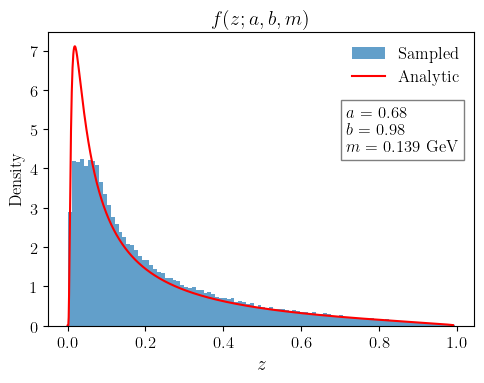

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))
# Plot histogram of sampled values
ax.hist(Z, bins=100, density=True, alpha=0.7, label = 'Sampled')
ax.set_xlabel(r'$z$', size = 14)
ax.set_ylabel('Density')

# Place parameters as text on the plot
params_text = f"$a$ = {a}\n$b$ = {b}\n$m$ = {m} GeV"
ax.text(0.7, 0.75, params_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
ax.set_title(r'$f(z; a, b, m)$')

# Overlay the theoretical Lund fragmentation function
fz = lambda z, m: ((1-z)**a / z) * np.exp(-(b * m**2) / z)
z_range = np.linspace(1e-5, 0.99, 1000)

# Calculate normalization factor by numerical integration
dz = z_range[1] - z_range[0]
norm_factor = np.sum(fz(z_range, m) * dz)

# Plot the normalized theoretical function
ax.plot(z_range, fz(z_range, m) / norm_factor, color='red', label = 'Analytic')
ax.legend(frameon = False)
fig.tight_layout()

Uniform accept-reject sampling isn't cutting it. We'll need to modify an implement some form of importance sampling. Let's also wrap it in its own class for posterity.

In [11]:
class StringZ:
    def __init__(self, a = 0.68, b = 0.98):
        self.a = a
        self.b = b

    def zLund(self, m):
        """
        Generate z from the Lund fragmentation function using importance sampling.
        """
        # Overhead constant
        _OVERHEAD = 5
        # Fragmentation function
        fz = lambda z, m: ((1-z)**self.a / z) * np.exp(-(self.b * m**2) / z)
        # Proposal function
        g = lambda z: _OVERHEAD - z
        # Sample trial value between 0 and 1
        z = np.random.uniform(0, 1)
        # Compute the weight
        w = fz(z, m) / g(z)
        # Compute the acceptance probability
        paccept = w / _OVERHEAD
        # Accept or reject the sample
        if np.random.uniform(0, 1) < paccept:
            return z
        else:
            return self.zLund(m)

In [12]:
# Create a sample of 1000 z values
a = 0.68 # Monash default
b = 0.98 # Monash default
m = 0.139 # GeV, pion mass

# Instantiate the StringZ class
stringZ = StringZ()

# Generate the sample using the accept-reject algorithm above
n_samples = 100000
Z = [stringZ.zLund(m) for _ in range(n_samples)]

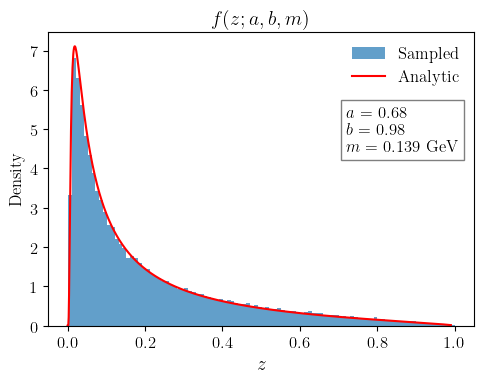

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))
# Plot histogram of sampled values
ax.hist(Z, bins=100, density=True, alpha=0.7, label = 'Sampled')
ax.set_xlabel(r'$z$', size = 14)
ax.set_ylabel('Density')

# Place parameters as text on the plot
params_text = f"$a$ = {a}\n$b$ = {b}\n$m$ = {m} GeV"
ax.text(0.7, 0.75, params_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
ax.set_title(r'$f(z; a, b, m)$')

# Overlay the theoretical Lund fragmentation function
fz = lambda z, m: ((1-z)**a / z) * np.exp(-(b * m**2) / z)
z_range = np.linspace(1e-5, 0.99, 1000)

# Calculate normalization factor by numerical integration
dz = z_range[1] - z_range[0]
norm_factor = np.sum(fz(z_range, m) * dz)

# Plot the normalized theoretical function
ax.plot(z_range, fz(z_range, m) / norm_factor, color='red', label = 'Analytic')
ax.legend(frameon = False)
fig.tight_layout()

## **Algorithmic overview**
To start, let's consider the fragmentation of the $q\bar{q}$ system in 1 + 1 dimensions $(E, p_z)$ or $(t, z)$. Later we'll see how transverse momentum is included via string breaking. In terms of the iterative program for the left-right symmetric Lund model it can be summarized as follows:

1. Randomly select from which string end the fragmentation will take place
2. Select new $q'\bar{q}'$ and hadron to be produced (`StringFlav`)
3. Sample $z$ according to the Lund fragmentation function (`StringZ`)
4. Compute production vertices
5. Update all momenta
6. Proceed through steps (1)-(5) until the center of mass energy of the new string system falls below a given cut off threshold $M^2_{\text{min}}$.

It's instructive to iterate through the algorithm a few time to get a feel. Let's assume, for simplicity, that we will only fragment from the $q$ side of the string (denoted as `fromPos` in the code). This is not how it's done in practice (typically a 50-50 coin flip between the $q$ or $\bar{q}$ end) but the simplification reduces the algorithmic complexity and readability. At the end of the day, allowing for the string to randomly fragment from either side only requires extra bookkeeping. We'll leave this implementation as an exercise. 

To start, we need to set up our $q\bar{q}$ system:

In [14]:
# Define the energy for each string end
e = 0.5 # GeV
# Create a QQBarString instance with the predefined quarks
qqbar = QQBarString(Eq = e, Eqbar = e, ParticleData = ParticleDatabase['u'])

Next we need a new hadron and string end, `StringFlav` is what we need:

In [15]:
# Initialize flavor selector
flavor_selector = StringFlav(ParticleDatabase)

# Get the end id of the string (from the q end)
end_id_0 = qqbar.q.data.pid 

# Select a flavor and get the new string and output hadron
new_string_end_1, output_had_1 =  flavor_selector.select_flavor(end_id_0)
print("Output hadron:\n", output_had_1, "\n")
print("New string id:\n", new_string_end_1)

Output hadron:
    pid: 211
  name: pi+
  mass: 0.13957
   tau: None
  spin: None
charge: 1
colour: None 

New string id:
    pid: 1
  name: d
  mass: 0.0
   tau: None
  spin: None
charge: -0.3333333333333333
colour: None


Now we need to sample a $z$ for the hadron, `StringZ` to the rescue:

In [16]:
# Instantiate the StringZ class
stringZ = StringZ()

# Generate one value of z, remember that this requires the mass of the hadron
z_had_1 = stringZ.zLund(output_had_1.mass)

print("z value for hadron 1:", z_had_1)

z value for hadron 1: 0.03884033912863205


Now we can compute the string break vertices. From above we know that 
$$
x^+_1 = z_1, \quad x^-_1 = \frac{m_1^2}{x^+_1 M^2}
$$
$$
\hat{x}^+_1 = \hat{x}^+_0 - x^+_1 = 1 - z_1^+
$$
$$
\hat{x}^-_1 = \hat{x}^-_0 + x^-_1 = \frac{m_1^2}{x^+_1 M^2}
$$

In [17]:
x_plus_1 = z_had_1
x_minus_1 = output_had_1.mass**2 / (x_plus_1 * qqbar.M2)
xhat_plus_1 = 1 - x_plus_1
xhat_minus_1 = x_minus_1

print(f"x_plus_1: {x_plus_1:.3f}, x_minus_1: {x_minus_1:.3f}")
print(f"xhat_plus_1: {xhat_plus_1:.3f}, xhat_minus_1: {xhat_minus_1:.3f}")

x_plus_1: 0.039, x_minus_1: 0.502
xhat_plus_1: 0.961, xhat_minus_1: 0.502


It will be useful visualize each break on the light-cone "unit square"

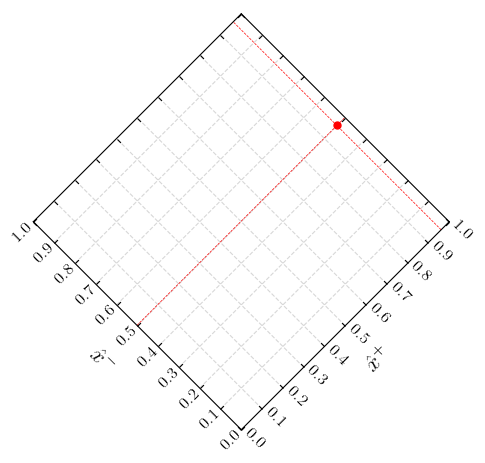

In [18]:
# Visualize the light-cone energy-momentum Lund plane
fig = plt.figure(figsize=(5, 5))

# Define the transformation (rotate by 45 degrees)
transform = Affine2D().rotate_deg(45)
helper = GridHelperCurveLinear(transform, extremes=(0, 1, 0, 1))
ax = FloatingSubplot(fig, 111, grid_helper=helper)
fig.add_subplot(ax)



# Create auxiliary axis to plot in original coordinates
aux_ax = ax.get_aux_axes(transform)

# Axis labels
ax.axis["left"].label.set_text(r"$\hat{x}^-$")
ax.axis["left"].label.set_size(17)
ax.axis["left"].label.set_rotation(0)
ax.axis["left"].label.set_pad(25)

ax.axis["bottom"].label.set_text(r"$\hat{x}^+$")
ax.axis["bottom"].label.set_size(17)
ax.axis["bottom"].label.set_pad(15)
ax.axis["bottom"].major_ticklabels.set_rotation(270)

# Draw a dotted line at xhat_plus_1 and xhat_minus_1
aux_ax.plot([xhat_plus_1, xhat_plus_1], [0, 1], linestyle='--', color='red', linewidth=0.5)
aux_ax.plot([0, 1], [xhat_minus_1, xhat_minus_1], linestyle='--', color='red', linewidth=0.5)

# Plot a point at (0.7, 0.1) using unrotated coordinates
aux_ax.plot(xhat_plus_1, xhat_minus_1, 'o', markersize=5, color = 'red')

# Add grid and legend
ax.grid(True, linestyle='--', alpha=0.5)
#aux_ax.legend(frameon=False, loc='upper right')
ax.set_aspect('equal')

fig.tight_layout()

Let's do the second iteration, which is a little more interesting

In [19]:
# Now we start with the new string end pid
new_string_end_2, output_had_2 =  flavor_selector.select_flavor(new_string_end_1.pid)
print("Output hadron:\n", output_had_2, "\n")
print("New string id:\n", new_string_end_2, "\n")

# Generate one value of z, remember that this requires the mass of the hadron
z_had_2 = stringZ.zLund(output_had_2.mass)

print("z value for hadron 1:", z_had_2)

Output hadron:
    pid: 111
  name: pi0
  mass: 0.134977
   tau: None
  spin: None
charge: 0.0
colour: None 

New string id:
    pid: 1
  name: d
  mass: 0.0
   tau: None
  spin: None
charge: -0.3333333333333333
colour: None 

z value for hadron 1: 0.407431260630837


For the new vertices let's rewrite everything in terms of quantities that we have access to, past or present:
$$
x^+_2 = z^+_2 (1 - z^+_1), \quad x^-_2 = \frac{m_2^2}{x^+_2 M^2} 
$$
$$
\hat{x}^+_2 = \hat{x}^+_1 - x^+_2, \quad \hat{x}^-_2 = \hat{x}^-_1 + x^-_2
$$

In [20]:
x_plus_2 = z_had_2 * (1 - z_had_1)
x_minus_2 = output_had_2.mass**2 / (x_plus_2 * qqbar.M2)
xhat_plus_2 = xhat_plus_1 - x_plus_2
xhat_minus_2 = xhat_minus_1 + x_minus_2

print(f"x_plus_2: {x_plus_2:.3f}, x_minus_2: {x_minus_2:.3f}")
print(f"xhat_plus_2: {xhat_plus_2:.3f}, xhat_minus_2: {xhat_minus_2:.3f}")

x_plus_2: 0.392, x_minus_2: 0.047
xhat_plus_2: 0.570, xhat_minus_2: 0.548


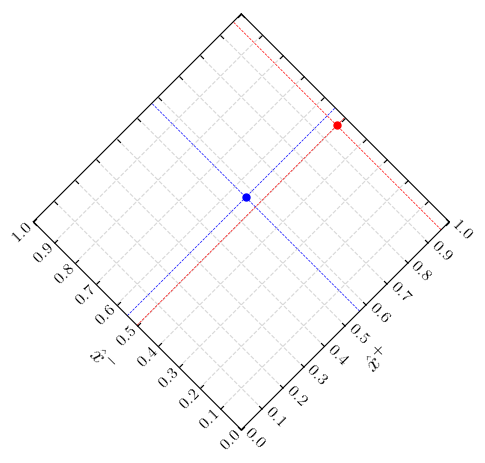

In [21]:
# Visualize the light-cone energy-momentum Lund plane
fig = plt.figure(figsize=(5, 5))

# Define the transformation (rotate by 45 degrees)
transform = Affine2D().rotate_deg(45)
helper = GridHelperCurveLinear(transform, extremes=(0, 1, 0, 1))
ax = FloatingSubplot(fig, 111, grid_helper=helper)
fig.add_subplot(ax)

# Create auxiliary axis to plot in original coordinates
aux_ax = ax.get_aux_axes(transform)

# Axis labels
ax.axis["left"].label.set_text(r"$\hat{x}^-$")
ax.axis["left"].label.set_size(17)
ax.axis["left"].label.set_rotation(0)
ax.axis["left"].label.set_pad(25)

ax.axis["bottom"].label.set_text(r"$\hat{x}^+$")
ax.axis["bottom"].label.set_size(17)
ax.axis["bottom"].label.set_pad(15)
ax.axis["bottom"].major_ticklabels.set_rotation(270)

# Draw a dotted line at xhat_plus_1 and xhat_minus_1
aux_ax.plot([xhat_plus_1, xhat_plus_1], [0, 1], linestyle='--', color='red', linewidth=0.5)
aux_ax.plot([0, 1], [xhat_minus_1, xhat_minus_1], linestyle='--', color='red', linewidth=0.5)

aux_ax.plot([xhat_plus_2, xhat_plus_2], [0, 1], linestyle='--', color='blue', linewidth=0.5)
aux_ax.plot([0, 1], [xhat_minus_2, xhat_minus_2], linestyle='--', color='blue', linewidth=0.5)

# Plot a point at (0.7, 0.1) using unrotated coordinates
aux_ax.plot(xhat_plus_1, xhat_minus_1, 'o', markersize=5, color = 'red')
aux_ax.plot(xhat_plus_2, xhat_minus_2, 'o', markersize=5, color = 'blue')

# Add grid
ax.grid(True, linestyle='--', alpha=0.5)

ax.set_aspect('equal')
fig.tight_layout()

Rinse and repeat. Eventually we will get to a point where energy and momentum conservation of the outgoing hadrons should creep up on us. For example, we will eventually reach a point where the remaining string mass is too small to produce any hadrons that we have access to - we should stop the fragmentation chain before we get here so we can maybe do something a little smarter. A possibly good condition would be to stop right around when the remaining area is roughly the size of two of the largest hadron masses that we can produce (remember, the last vertex that we select is actually producing the **final two** hadrons), which in our case, is just two pions
$$
\hat{x}^+_n(1 - \hat{x}^-_n)M^2 \approx (2m_\pi)^2
$$

### **Iterative fragmentation**
Before we implement the full algorithm, we need to be able to convert from the momentum fractions to (in principle observable) hadron four-momenta. Consider the four-vectors 
$$
P_{q/\bar{q}}^{\mu} \equiv E(1, 0, 0, \pm 1)
$$ 
(in our language these are just four-momenta of the $q\bar{q}$ system that we initialize in `QQBarString` as `self.q_p`. `self.qbar_p`), and remember that the $i$-th ($i \in 1, ..., N_h$) hadron coordinate can be described generically by
$$
x_{i}^+ = \hat{x}_{i-1}^+ - \hat{x}_i^+,
$$
$$
x_{i}^- = \hat{x}_i^- - \hat{x}_{i-1}^-
$$
with $\hat{x}^+_0 = 1, \hat{x}^-_0 = 0$. The hadron momentum is then fully described by the system of equations
$$
  	p^\mu_{i} = x_{i}^+ P^\mu_q + x_{i}^- P^\mu_{\bar{q}}
$$
or simply
$$
    E_{i} = E(x^+_{i} + x^-_{i}), \hspace{0.3in} p_{z, i} =  E(x^+_{i} - x^-_{i})
$$
constrained by the condition
$$
    m_{i}^2 = p_{i}^2 = x^+_{i}x^-_{i} M^2.
$$
In practice, given the mass of the new hadron $m_{i}$ and longitudinal momentum fraction $z_i$, we'll compute the new vertex $i$ via
$$
    x^{+}_{i} = z^{+}_{i}\prod_{j=1}^{i-1}(1-z^{+}_j) \quad \text{for } \,\, i > 1
$$
$$
    x^{-}_{i} = \frac{m^2_{i}}{x^{+}_{i}M^2}
$$
where $z^{+}_0 = 0$. Finally, the position ($\hat{x}^+_i, \hat{x}^-_i$) of the $i$-th vertex can also be found recursively using the expressions above
$$
\hat{x}^+_i = \hat{x}^+_{i-1} - x_i^+ = (1 - z_i) \hat{x}^+_{i-1}
$$
$$
\hat{x}^-_i = \hat{x}^-_{i-1} + x_i^-.
$$

Let's build out a `StringFragmentation` class below that will take as input `QQBarString`, `StringFlav`, and `StringZ` instances and recursively fragment the string system resulting in an event record consisting of hadron four-momenta. 

In [22]:
class StringFragmentation:
    def __init__(self, QQBarString, StringFlav, StringZ, ParticleDatabase):
        """
        Initialize the Hadronization class with a QQBarString and particle database.
        """
        self.qqbar = QQBarString
        self.string_z = StringZ
        self.flav_sel = StringFlav
        self.pdb = ParticleDatabase

        # Initialize the event records 
        self.event_record = np.array([self.qqbar.q, self.qqbar.qbar])

        # Initialize arrays for our light-cone coordinates
        self.x_plus = np.array([])
        self.x_minus = np.array([])
        self.xhat_plus = np.array([1.0])
        self.xhat_minus = np.array([0.0])

        # Initialize arrays for z values
        self.z = np.array([0.0])

        # Since we're starting from the positive end we can initialize the first string end id
        self.end_id = self.qqbar.q.data.pid
    
    def fragment(self, end_id):
        """
        Perform a single fragmentation step.
        """
        # Select a flavor for the new hadron
        new_string_end, output_hadron = self.flav_sel.select_flavor(end_id)
        # Sample z
        z = self.string_z.zLund(output_hadron.mass)

        return z, output_hadron, new_string_end
    
    def hadronize(self):
        """
        Recursively hadronize the string.
        """ 
        # Fragment the string    
        z, output_hadron, new_string_end = self.fragment(self.end_id)
 
        # Record z and x_+/-, xhat_+/-
        self.z          = np.append(self.z, z)
        self.x_plus     = np.append(self.x_plus, z * np.prod(1 - self.z[:-1]))
        self.x_minus    = np.append(self.x_minus, output_hadron.mass**2 / (self.x_plus[-1] * self.qqbar.M2))
        self.xhat_plus  = np.append(self.xhat_plus, self.xhat_plus[-1] - self.x_plus[-1])
        self.xhat_minus = np.append(self.xhat_minus, self.xhat_minus[-1] + self.x_minus[-1])

        # Add the new hadron to the event record
        E_i = self.qqbar.E * (self.x_plus[-1] + self.x_minus[-1])
        pz_i = self.qqbar.E * (self.x_plus[-1] - self.x_minus[-1])
        p_i = FourVector(E_i, 0, 0, pz_i)
        # At new Particle instance to the event record
        self.event_record = np.append(self.event_record, Particle(data = ParticleDatabase[output_hadron.name], p = p_i, h=0.))

        # Set the new string end id
        self.end_id = new_string_end.pid
        
        # If the final vertex goes into an unphysical region, pop the last vertex and terminate
        if self.xhat_minus[-1] > 1.0 or self.xhat_plus[-1] < 0.0:
            # Pop the last vertex from all arrays and return
            self.xhat_plus = self.xhat_plus[:-1]
            self.xhat_minus = self.xhat_minus[:-1]
            self.x_plus = self.x_plus[:-1]
            self.x_minus = self.x_minus[:-1]
            self.z = self.z[:-1]
            self.event_record = self.event_record[:-1]
            return
        # Check the stopping condition
        elif self.xhat_plus[-1] * (1 - self.xhat_minus[-1]) * self.qqbar.M2 < (2 * self.pdb['pi+'].mass)**2:
            return
        else: self.hadronize()

    def neuralize(self):
        """
        Reset the string fragmentation state (sorry for the MIB reference).
        """
        self.event_record = np.array([self.qqbar.q, self.qqbar.qbar])
        self.x_plus = np.array([])
        self.x_minus = np.array([])
        self.xhat_plus = np.array([1.0])
        self.xhat_minus = np.array([0.0])
        self.z = np.array([0.0])
        self.end_id = self.qqbar.q.data.pid


In [23]:
e = 3.0 # GeV
stringZ = StringZ()
stringFlav = StringFlav(ParticleDatabase)
qqbar = QQBarString(Eq = e, Eqbar = e, ParticleData = ParticleDatabase['u'])
stringFrag = StringFragmentation(qqbar, stringFlav, stringZ, ParticleDatabase)
stringFrag.hadronize()

In [24]:
print('z:\n', stringFrag.z, '\n')
print('xhat_plus:\n', stringFrag.xhat_plus, '\n')
print('xhat_minus:\n', stringFrag.xhat_minus, '\n')
print('x_plus:\n', stringFrag.x_plus, '\n')
print('x_minus:\n', stringFrag.x_minus)

z:
 [0.         0.83747884 0.1034533  0.03508539 0.30928597 0.14488269
 0.90121325 0.22052589 0.61246851] 

xhat_plus:
 [1.         0.16252116 0.14570781 0.14059559 0.09711135 0.0830416
 0.00820341 0.00639434 0.00247801] 

xhat_minus:
 [0.00000000e+00 6.04286927e-04 3.27873507e-02 1.38632894e-01
 1.50271075e-01 1.88729825e-01 1.95492115e-01 4.94599893e-01
 6.32766102e-01] 

x_plus:
 [0.83747884 0.01681335 0.00511221 0.04348425 0.01406975 0.07483819
 0.00180906 0.00391633] 

x_minus:
 [0.00060429 0.03218306 0.10584554 0.01163818 0.03845875 0.00676229
 0.29910778 0.13816621]


In [25]:
print('Hadronizing system:\n')
print(qqbar, '\n')

print('Event record:\n')
for event in stringFrag.event_record:
    name = event.data.name
    p = event.p
    print(f"{name:>6}: (E={p[0]:.3f}, px={p[1]:.3f}, py={p[2]:.3f}, pz={p[3]:.3f}, m={np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2):.3f})")

Hadronizing system:

QBarQ(   q:FourVector(E=3.000, px=0.000, py=0.000, pz=3.000, m=0.000),
      qbar:FourVector(E=3.000, px=0.000, py=0.000, pz=-3.000, m=0.000)) 

Event record:

     u: (E=3.000, px=0.000, py=0.000, pz=3.000, m=0.000)
  ubar: (E=3.000, px=0.000, py=0.000, pz=-3.000, m=0.000)
   pi0: (E=2.514, px=0.000, py=0.000, pz=2.511, m=0.135)
   pi+: (E=0.147, px=0.000, py=0.000, pz=-0.046, m=0.140)
   pi-: (E=0.333, px=0.000, py=0.000, pz=-0.302, m=0.140)
   pi0: (E=0.165, px=0.000, py=0.000, pz=0.096, m=0.135)
   pi+: (E=0.158, px=0.000, py=0.000, pz=-0.073, m=0.140)
   pi0: (E=0.245, px=0.000, py=0.000, pz=0.204, m=0.135)
   pi-: (E=0.903, px=0.000, py=0.000, pz=-0.892, m=0.140)
   pi+: (E=0.426, px=0.000, py=0.000, pz=-0.403, m=0.140)


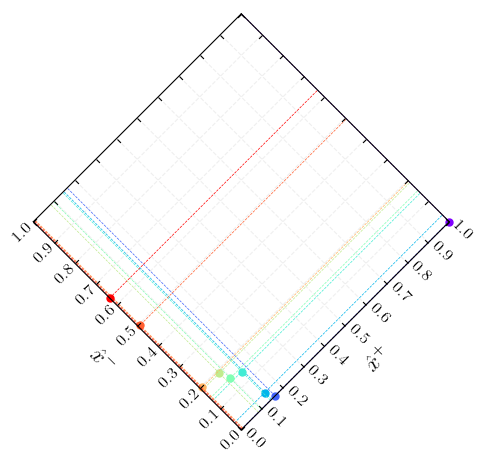

In [26]:
# Visualize the light-cone energy-momentum Lund plane
fig = plt.figure(figsize=(5, 5))

# Define the transformation (rotate by 45 degrees)
transform = Affine2D().rotate_deg(45)
helper = GridHelperCurveLinear(transform, extremes=(0, 1, 0, 1))
ax = FloatingSubplot(fig, 111, grid_helper=helper)
fig.add_subplot(ax)

# Create auxiliary axis to plot in original coordinates
aux_ax = ax.get_aux_axes(transform)

# Axis labels
ax.axis["left"].label.set_text(r"$\hat{x}^-$")
ax.axis["left"].label.set_size(17)
ax.axis["left"].label.set_rotation(0)
ax.axis["left"].label.set_pad(25)

ax.axis["bottom"].label.set_text(r"$\hat{x}^+$")
ax.axis["bottom"].label.set_size(17)
ax.axis["bottom"].label.set_pad(15)
ax.axis["bottom"].major_ticklabels.set_rotation(270)

# Create a colormap with distinct colors based on the number of vertices
num_vertices = len(stringFrag.xhat_plus)
colors = plt.cm.rainbow(np.linspace(0, 1, num_vertices))

for i, (xhat_plus, xhat_minus) in enumerate(zip(stringFrag.xhat_plus, stringFrag.xhat_minus)):
    # Draw a dotted line at xhat_plus and xhat_minus
    aux_ax.plot([xhat_plus, xhat_plus], [0, 1], linestyle='--', color=colors[i], linewidth=0.5)
    aux_ax.plot([0, 1], [xhat_minus, xhat_minus], linestyle='--', color=colors[i], linewidth=0.5)
    # Plot a point at (xhat_plus, xhat_minus) using unrotated coordinates
    aux_ax.plot(xhat_plus, xhat_minus, 'o', markersize=5, color=colors[i])

# Add grid
ax.grid(True, linestyle='--', alpha=0.2)

ax.set_aspect('equal')
fig.tight_layout()

In [27]:
# Let's also create a 2d histogram of an ensemble of xhat_plus and xhat_minus values
nevents = 10000
xhat_plus_values = np.array([])
xhat_minus_values = np.array([])

# Initialize the string fragmentation instance
stringFrag_i = StringFragmentation(qqbar, stringFlav, stringZ, ParticleDatabase)

for i in range(nevents):
    # Reset the state for each event
    stringFrag_i.neuralize()
    # Hadronize the string
    stringFrag_i.hadronize() 
    # Append all of the xhat_plus and xhat_minus values to the arrays (flattened)
    xhat_plus_values = np.append(xhat_plus_values, stringFrag_i.xhat_plus[1:])
    xhat_minus_values = np.append(xhat_minus_values, stringFrag_i.xhat_minus[1:])

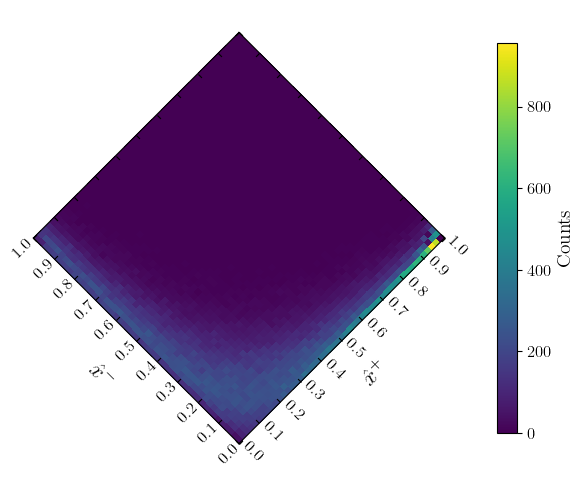

In [28]:
fig = plt.figure(figsize=(6, 6))

# Define the transformation (rotate by 45 degrees)
transform = Affine2D().rotate_deg(45)
helper = GridHelperCurveLinear(transform, extremes=(0, 1, 0, 1))
ax = FloatingSubplot(fig, 111, grid_helper=helper)
fig.add_subplot(ax)

# Create auxiliary axis to plot in original coordinates
aux_ax = ax.get_aux_axes(transform)

# Axis labels
ax.axis["left"].label.set_text(r"$\hat{x}^-$")
ax.axis["left"].label.set_size(17)
ax.axis["left"].label.set_rotation(0)
ax.axis["left"].label.set_pad(25)

ax.axis["bottom"].label.set_text(r"$\hat{x}^+$")
ax.axis["bottom"].label.set_size(17)
ax.axis["bottom"].label.set_pad(15)
ax.axis["bottom"].major_ticklabels.set_rotation(270)

_, _, _, hist_xhat_pm = aux_ax.hist2d(xhat_plus_values, xhat_minus_values, bins=50, range=[[0, 1], [0, 1]], cmap='viridis')
# Add a colorbar
cbar = fig.colorbar(hist_xhat_pm, ax=ax, orientation='vertical', fraction=0.04, pad=0.1)
cbar.set_label('Counts', size=14)

ax.set_aspect('equal')
fig.tight_layout()
plt.show()

You'll see above that the vertices seem to follow some sort of hyperbolic distribution - this can be traced back to some interesting physics! Generically, the unnormalized probability for a string break to fragment into an $n$-particle final state is given by
$$
dP_n = \prod_{j = 1}^n N_j dp_j \delta(p_j^2 - m_j^2) \delta\left( \sum_{j=1}^n p^\mu_j - P^\mu_{\text{string}} \right) \exp(-b \mathcal{A})
$$
where $\mathcal{A}$ represents the area spanned by the string before the breakup. The probability roughly factorizes into the product of $n$-body phase space with an exponential area suppression. This competition leads to an interesting compromise. On one hand, phase space wants to pack in as many hadrons as possible — which tends to push fragmentation vertices closer together in time. On the other hand, the exponential suppression penalizes any configuration that sweeps out too much area — i.e., configurations where hadrons are produced too far apart in time or space. The balance point turns out to be when each breakup contributes roughly the same invariant area. That is, the most probable configurations are those where the fragmentation vertices lie along curves of constant invariant time:
$$
\tau^2 = t^2 - z^2 = \text{const}.
$$
These hyperbolae strike a balance between maximizing multiplicity and minimizing total area. Physically, this means that the string fragments in a boost-invariant fashion.

This structure has important observable consequences, for example the coordinate-space rapidity of a vertex is defined as
$$
\eta = \frac{1}{2} \ln\left(\frac{t + z}{t - z}\right),
$$
and since the vertices lie along a fixed $\tau$, their density in $\eta$ is approximately uniform.

This geometric picture is also encoded in our **Lund plane** that we constructed above. To see this we introduce the the the squared invariant time (from the origin of the initial $q\bar{q}$ pair) to a string break vertex
$$
\Gamma = (\kappa \tau)^2 = \kappa^2 (t^2 - x^2 - y^2 - z^2).
$$
In the energy-momentum picture, this is simply given by
$$
\Gamma_i = (\hat{x}^+_i P^+ + \hat{x}^-_i P^-)^2 = \hat{x}_i^+ \hat{x}_i^- M^2,
$$
which corresponds geometrically to the string area in the backwards light cone of the vertex. The area suppression factor from above then becomes
$$
\exp(-b \mathcal{A}) = \exp\left(-b \sum_i \Gamma_i \right).
$$
To avoid exponential suppression, the hadronization configurations will prefer for each $\Gamma_i$ to small but roughly equal, i.e., each hadron is produced along a contour of constant $\hat{x}^+ \hat{x}^-$, which traces out a **hyperbola** on the unit square (as we see above!). This is a direct imprint of the same physical principle above: balancing the statistical pressure to produce many hadrons with the geometric penalty for large invariant area.

Similar to the coordinate space rapidity, $\eta$, we can clearly see that the momentum-space rapidity
$$
y = \frac{1}{2} \ln\left(\frac{E + p_z}{E - p_z}\right) = \frac{1}{2} \ln\left(\frac{p^+}{p^-}\right) = \frac{1}{2} \ln\left(\frac{x^+}{x^-}\right)
$$ 
will also remain roughly constant i.e. the number of particles produced, $N$, per unit rapidity 
$$
\frac{dN}{dy} \approx \text{const}.
$$ 
To summarize, the area suppression sculpts the entire fragmentation pattern into hyperbolic structure that ensures boost invariance and a flat rapidity distribution.

Before we continue on to incorporating tranverse momentum, let's look at some observables.

In [38]:
# Let's run many events and see what some observables look like
n_events = 10000
multiplicity = np.zeros(n_events)

stringFrag_i = StringFragmentation(qqbar, stringFlav, stringZ, ParticleDatabase)
for i in range(n_events):
    # Reset the state for each event
    stringFrag_i.neuralize()
    # Hadronize the string
    stringFrag_i.hadronize()
    multiplicity[i] = len(stringFrag_i.event_record) - 2 # Subtract the two string ends

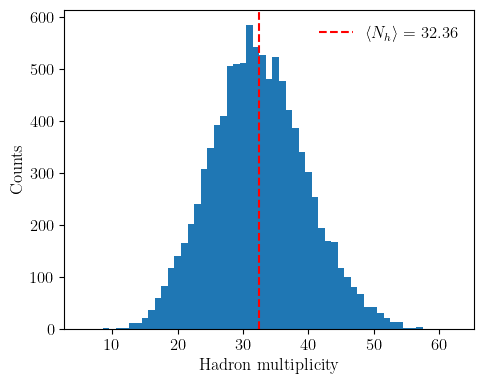

In [39]:
fig, ax = plt.subplots(figsize=(5, 4))

# Fix the number of bins to the min and max multiplicity
mult_max = int(np.max(multiplicity))
mult_min = int(np.min(multiplicity))

# Construct a binning
bins = np.arange(mult_min, mult_max + 1) + 0.5  # Add 0.5 to center the bins

# Compute the average multiplicity
avg_multiplicity = np.mean(multiplicity)

# Plot histogram of multiplicity
ax.hist(multiplicity, bins=bins)

# Plot the average multiplicity as a vertical line
ax.axvline(avg_multiplicity, color='red', linestyle='--', label=rf'$\langle N_h \rangle=$ {avg_multiplicity:.2f}')

# Set labels and legend
ax.set_xlabel('Hadron multiplicity')
ax.set_ylabel('Counts')

ax.legend(frameon = False)
fig.tight_layout()

In [31]:
n_events = 10000
rapidity = np.array([])
# Define the rapidity function
y = lambda x_plus, x_minus: 0.5 * np.log(x_plus / x_minus)

stringFrag_i = StringFragmentation(qqbar, stringFlav, stringZ, ParticleDatabase)

for i in range(n_events):
    # Reset the state for each event
    stringFrag_i.neuralize()
    # Hadronize the string
    stringFrag_i.hadronize()
    # Compute rapidity for each hadron in the event record
    for i, hadron in enumerate(stringFrag_i.event_record):
        if i < 2:
            continue
        # Compute rapidity for the hadron
        rapidity = np.append(rapidity, y(stringFrag_i.x_plus[i-2], stringFrag_i.x_minus[i-2]))

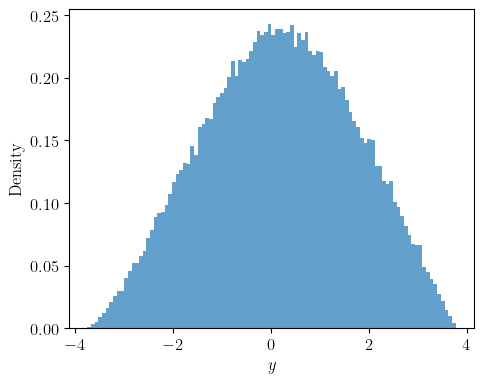

In [32]:
fig, ax = plt.subplots(figsize=(5, 4))

# Plot histogram of rapidity
ax.hist(rapidity, bins=100, density=True, alpha=0.7)
# Set labels
ax.set_xlabel(r'$y$')
ax.set_ylabel('Density')
fig.tight_layout()

We mentioned above that the rapidity distribution should be flat? What is going on? The caveat to the statements above is that they hold primarily in the limit of "infinitely long" or very massive strings. The reason for this is because the relation doesn't hold near the end of the string. Let's take a look at the scaling of the rapidity distribution as a function of the string mass.

In [33]:
n_events = 5000
rapidity = []
# Define the rapidity function
y = lambda x_plus, x_minus: 0.5 * np.log(x_plus / x_minus)

# Let's see how the rapidity evolves with the mass of the string
E = [5., 10.0, 25.0, 50.] # Gev

for e in E:
    qqbar = QQBarString(Eq = e, Eqbar = e, ParticleData = ParticleDatabase['u'])
    stringFrag_i = StringFragmentation(qqbar, stringFlav, stringZ, ParticleDatabase)
    rapidity_e = []
    for i in range(n_events):
        # Reset the state for each event
        stringFrag_i.neuralize()
        # Hadronize the string
        stringFrag_i.hadronize()
        # Compute rapidity for each hadron in the event record
        for j, hadron in enumerate(stringFrag_i.event_record):
            if j < 2:
                continue
            # Compute rapidity for the hadron
            rapidity_e.append(y(stringFrag_i.x_plus[j-2], stringFrag_i.x_minus[j-2]))
    rapidity.append([rapidity_e])

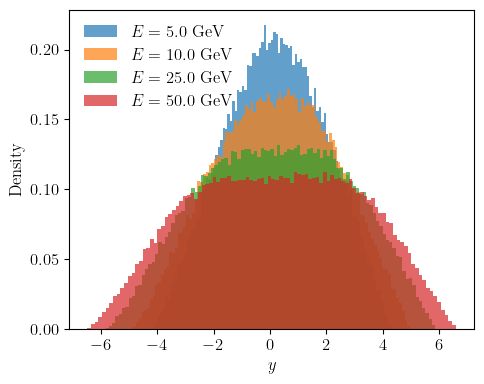

In [34]:
fig, ax = plt.subplots(figsize=(5, 4))

# Plot histogram of rapidity
for i, e in enumerate(E):
    # Plot each rapidity distribution with a label
    ax.hist(rapidity[i], bins=100, density=True, alpha=0.7, label=f'$E = {e}$ GeV')

# Set labels and legend
ax.set_xlabel(r'$y$')
ax.set_ylabel('Density')
ax.legend(frameon = False)
fig.tight_layout()

## **What about $p_T$?**
Up until now we have worked exclusively in 1+1 dimensions with each string break (and therefore each hadron) having no transverse momenta. For a realistic hadronization simulation $p_T$ generation must be incorporated! 

In the Lund string model, each string break corresponds to the nonperturbative creation of a $q'\bar{q}'$ pair from the vacuum. This is modeled as a quantum tunneling process through the linear confining potential of the string. According to the uncertainty principle, this pair can have non-zero momentum transverse to the string axis. Since they are produced locally, momentum conservation requires that the transverse momenta of the quark and antiquark be equal and opposite i.e. each string break introduces a local transverse momentum kick, with 
$$
\vec{k}_\perp^{(q')} = -\vec{k}_\perp^{(\bar{q}')}.
$$
The resulting hadron inherits this transverse momentum when a quark from one break and an antiquark from the next recombine.

The tunneling probability for producing a quark of mass $m_q$ and transverse momentum $p_\perp$ is given by the Schwinger-like exponential suppression:
$$
\mathcal{P}(m_q, p_\perp) \propto \exp\left( -\frac{\pi (m_q^2 + p_\perp^2)}{\kappa} \right)
$$
where $\kappa \sim 1\,\mathrm{GeV}/\mathrm{fm} \simeq 0.2\,\mathrm{GeV}^2$ is the string tension. Note that heavier quarks and large transverse momenta are exponentially suppressed. Thus, strange quark production is rarer than up/down, and charm production is highly suppressed.

## **Algorithmic overview w/ $p_T$**
Fortunately, the iterative algorithm only requires minimal changes and can be largely summarized with the transformation: $m^2 \to m^2_\perp \equiv m^2 + p_T^2$ where $m_\perp$ is the **transverse mass**. 

In light-cone coordinates, transverse momentum components completely factorize from the longitudinal components (they are orthogonal). All light-cone variable definition remain the same as defined previously with the key change coming from the on-shell condition:
$$
p^+ p^- = m^2 + p_T^2 \equiv m_\perp^2.
$$
Likewise, the momentum fractions become
$$
x^+ x^- = \frac{m_\perp^2}{M^2}.
$$
Because $p_T$ completely factorizes (in terms of it's generation) the $p_T$ of the $i$-th hadron can be computed recursively via the string end transverse momentum $\vec{k}_T$
$$
\vec{p}_{T,i} = \vec{k}_{T,i} - \vec{k}_{T, i-1}, \quad \text{with} \quad \vec{k}_{T,0} = 0.
$$
Clearly the first hadron will have the same $p_T$ as the first string break $\vec{k}_{T,1}$, while the second hadron will inherit $p_T$ that is the vector sum of the first string break (whose conjugate end imparted some equal and opposite $\vec{k}_T$ on the leftover string system) and the $\vec{k}'_T$ of the new string break. 
 
### **Sampling $z$**
Even though the fragmentation happens longitudinally, the string area law (which governs hadron production probability) becomes sensitive to the full mass of the hadron, including transverse motion. So transverse momentum acts like an effective mass penalty - heavier hadrons or those with larger $p_T$ are suppressed. As you may have guessed, the fragmentation function becomes:
$$
f(z, p_\perp^2) \propto \frac{1}{z}(1 - z)^a \exp\left( -b\frac{m^2_\perp}{z} \right).
$$
Note that this implies that when determining kinematics, we first need to generate the string end transverse momentum components before determining the longitudinal component.

### **Sampling $p_T$**
In practice, the transverse momentum of the produced hadron is sampled **at each string break**, assuming that the distribution is azimuthally symmetric.

The transverse momentum is sampled from a Gaussian:
$$
f(\vec{p}_\perp) \propto \exp\left( -\frac{p_\perp^2}{\sigma^2} \right)
\quad \text{with} \quad \sigma^2 \approx \frac{\kappa}{\pi}
$$
where $\sigma$ is a tuneable parameter fit from experimental data. In PYTHIA, the default value is typically $\sigma \sim 0.3\,\mathrm{GeV}$.

### **Exercise**
First, write a `StringPT` class to generate samples of transverse momentum and then modify `StringFragmentation` to incorporate $p_T$ generation.

### **Exercise**
Throughout this tutorial we have chosen the Lund model parameters based off of the current PYTHIA defaults: `a = 0.68, b = 0.98, sigma = 0.335`. Change these parameters and investigate how this changes the observables of interest. Think about how you could set up an iterative tuning of these parameters if given experimental data. **Challenge:** Set up a mock tuning exercise using two simulated samples (of observables) at different parameterizations. Set one as the "experimental" dataset and the other as output from the simulation. See also the `tuning.ipynb` tutorial.

# **TBD**

## **Energy-momentum conservation (the $\texttt{finalTwo}$ hadrons)**

## **Gluons as string "kinks"**